Shortened workbench for analysing the shapefiles using pandas

In [1]:
from sinuutils import readshapestopandas

riverid = 7 # id of channel being analysed (CM_riverid)
channelname = 'sinuosity_shapefiles/sin_CM7.shp' # define channel to be analysed
yearrivers = readshapestopandas(channelname)
#yearrivers - uncomment out to see dataset
# in yearrivers shapeid from readshapestopandas is the year that the profile was drawn


In [2]:
# import shapefile which contains the valley slopes for different years

valleyslope = 'sinuosity_shapefiles/valley_slope_prof_wgs84.shp'

direct_profiles = readshapestopandas(valleyslope)

# in this shapefile, the 'shapeid' is not a year but the id of the channel
# call the correct channel id using riverid

direct_profile = None
for shapeid, d in direct_profiles:
    if shapeid == riverid:
        direct_profile = d

# direct_profile  - uncomment out to see dataset

Text(0, 0.5, 'y position [m]')

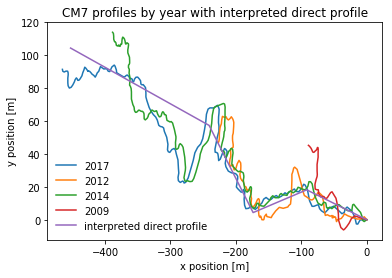

In [3]:
%matplotlib inline 
from matplotlib import pyplot as plt

for year, df in yearrivers:
    plt.plot(df.x, df.y, label='%d' % year)
    
plt.plot(direct_profile.x, direct_profile.y, label='interpreted direct profile')
#plt.axis('equal')
plt.legend(loc='lower left',frameon=False)  
plt.title('CM%d profiles by year with interpreted direct profile' % riverid)
plt.xlabel('x position [m]')
plt.ylabel('y position [m]')

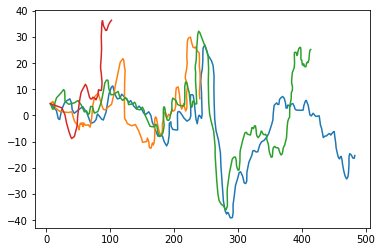

In [4]:
from sinuutils import transaxis
import numpy as np

# warptodirect: function which transforms the profile of a river channel 
# into a straight line plane following the x-axis of zero whilst also transforming the 
# direct profile ie valley slope to a linear profile as well, thus straightening both 
# and making them follow a linear trend. Then sinuosity is caalculated in one plane only

def warptodirect(direct_profile, df):
    sx, sy = df.x, df.y
    ax, ay = direct_profile.x, direct_profile.y

    cwtx, cwty, cw = sx*0, sx*0, sx*0 # make same size zero arrays
    ar = direct_profile.ar
    for i in range(1, len(ar)):
        ax0, ax1 = ax[i-1], ax[i]
        ay0, ay1 = ay[i-1], ay[i]
        r0, r1 = ar[i-1], ar[i]
        tx, ty, tw = transaxis(r0, r1, ax0, ax1, ay0, ay1, sx, sy)
        cwtx, cwty = cwtx + tx*tw, cwty + ty*tw
        cw = cw + tw
        #plt.plot([r0, r1], [0, 0], color="k")
        #plt.plot(tx, tw, label='%d' %i)   # uncomment this to show the weighting plots

    straightenedx, straightenedy = cwtx/cw, cwty/cw
    df["straightenedx"], df["straightenedy"] = straightenedx, straightenedy
    
    vx = (df.straightenedx - df.straightenedx.shift()).fillna(0)
    vy = (df.straightenedx - df.straightenedx.shift()).fillna(0)
    df["straightenedsegleng"] = np.sqrt(vx**2 + vy**2)
    return straightenedx, straightenedy
    
for year, df in yearrivers:
    straightenedx, straightenedy = warptodirect(direct_profile, df)
    plt.plot(straightenedx, straightenedy, label="%d" % year)
    


need to resample distances along the path using np.interp so that window size is consistent in the next section and bears some relevance to reality

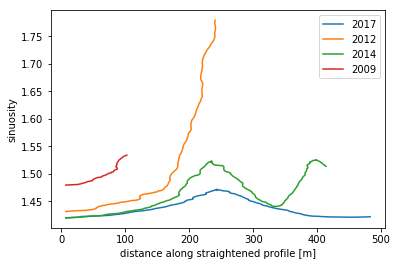

In [5]:
# calculate windowed sinuosity of the river channel
import numpy as np
from sinuutils import makeweightseries

def windowed_sinuosity(df):
    
    # make unit lengths
    unitx = (df.straightenedx - df.straightenedx.shift()).fillna(0)                   
    wxs = [ ]
    wsin = [ ]
    centreweightlength = 50 # change as appropriate
    for centreweightindex in range(len(df.straightenedx)):
        w = makeweightseries(df.straightenedx, centreweightindex, centreweightlength)
        wx = sum(w*df.straightenedx)/sum(w)
        weightedstreamlength = sum(df.straightenedsegleng*w)/sum(w)
        weighteddirectlength = sum(unitx*w)/sum(w)
        weightedsinuosity = weightedstreamlength/weighteddirectlength
        wsin.append(weightedsinuosity)
        wxs.append(wx)

    wxs = np.array(wxs)
    awsin = np.array(wsin)
    return wxs, awsin

# calculate windowed sinuosity for each given year
for year, df in yearrivers:
    wxs, awsin = windowed_sinuosity(df)
    df['windowedsin'] = awsin
    plt.plot(df.straightenedx,awsin, label='%d' %year)
    
plt.xlabel('distance along straightened profile [m]')
plt.ylabel('sinuosity')
plt.legend()


In [6]:
yearrivers

[(2017,
             lat        lng           x          y    segleng          ar  \
  0    31.330462  35.537472    0.000000   0.000000   0.000000    0.000000   
  1    31.330461  35.537364  -10.218691  -0.162086  10.219977   10.219977   
  2    31.330438  35.537327  -13.797533  -2.651367   4.359430   14.579407   
  3    31.330439  35.537304  -15.942242  -2.557044   2.146781   16.726188   
  4    31.330475  35.537280  -18.230253   1.451490   4.615555   21.341743   
  5    31.330504  35.537242  -21.905696   4.603782   4.842089   26.183832   
  6    31.330514  35.537217  -24.224235   5.728110   2.576769   28.760601   
  7    31.330531  35.537156  -30.043935   7.675248   6.136795   34.897396   
  8    31.330521  35.537124  -33.039784   6.564876   3.195002   38.092398   
  9    31.330502  35.537110  -34.426755   4.409160   2.563358   40.655755   
  10   31.330495  35.537073  -37.958895   3.647234   3.613384   44.269139   
  11   31.330515  35.537009  -44.031024   5.911218   6.480461   50.7

next step: plot heatmap of sinuosity with distance along channel (x axis) vs time (y axis)

In [43]:
# create a new dataframe storing sinuosity values for the channel according to year (rows) and 
# distance along the channel (columns)

import pandas as pd

reformed_df = [ ]
reformed_dfpivot = [ ]

for year, df in yearrivers:
    dftwo = pd.DataFrame({"xpos":df.straightenedx, "year":year, "sinuosity":df.windowedsin})
    reformed_df.append(dftwo)
    #dftwopivot = df_two.pivot(index='year', columns='xpos', values='sinuosity')
    #reformed_dfpivot.append(dftwopivot)


    



In [44]:
df_two.pivot(index='year', columns='xpos', values='sinuosity')

ValueError: Index contains duplicate entries, cannot reshape

ValueError: cannot copy sequence with size 214 to array axis with dimension 3

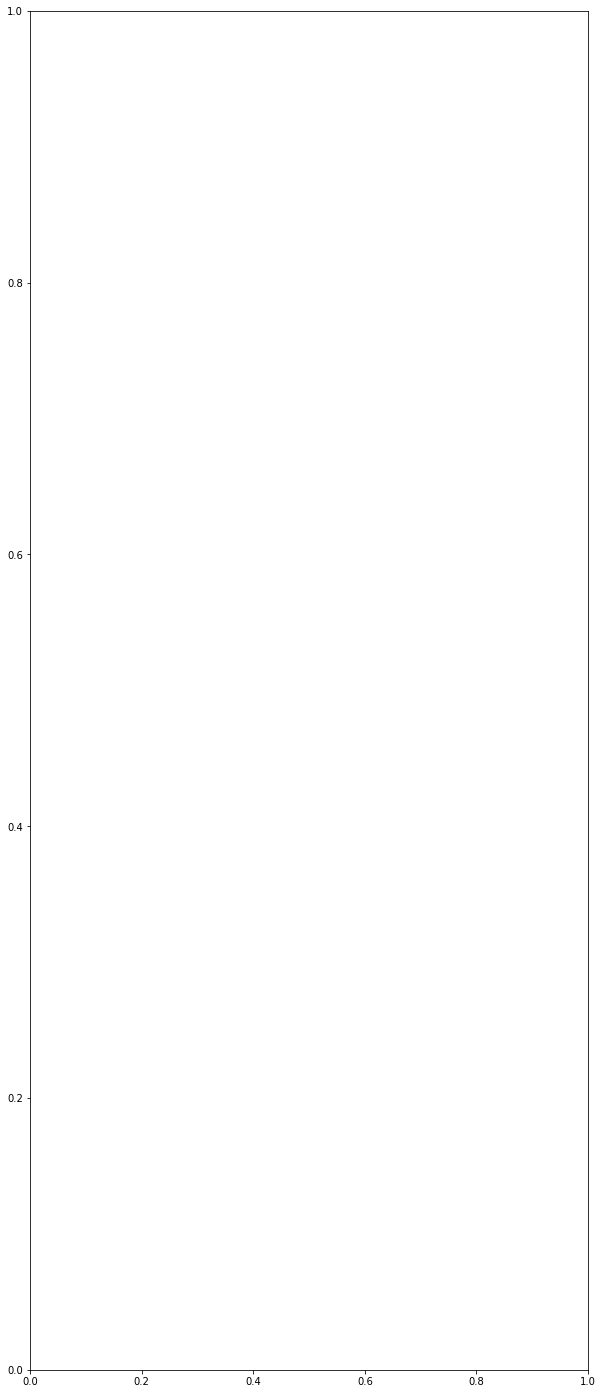

In [28]:
# create heatmap of sinuosity with time along length of a given channel using seaborn

import seaborn as sns

# use pivot to revisualise dataset
sin_length_year = reformed_df.pivot(index='year', columns='xpos', values='sinuosity')

# set up the plot
fig, ax = plt.subplots(figsize=(10, 25))
sns.heatmap(reformed_df, cmap='RdYlGr', ax=ax)

In [45]:
sin_length_year = df_two.pivot(index='year', columns='xpos', values='sinuosity')

ValueError: Index contains duplicate entries, cannot reshape

In [33]:
sin_length_year

xpos,6.729163507506086,24.585006547763882,29.269869682667643,32.11355715980002,35.55863694519482,38.518911363596686,39.91857262682771,44.193650999093485,48.58002844887904,48.92273022622772,...,90.2278904747375,91.76899723884755,92.28129505150766,93.44952097590176,94.84812461161927,95.86666798814377,96.89728128894177,98.00679580444944,100.59366117342695,102.3297521279719
year,,,,,,,,,,,,,,,,,,,,,
2009,1.479492,1.480476,1.481468,1.482468,1.483476,1.484491,1.485513,1.486542,1.487578,1.48862,...,1.525304,1.52632,1.527327,1.528322,1.529306,1.530278,1.531237,1.532183,1.533115,1.534033
